# Permutation Flow-Shop Scheduling Problem

This is a variant of the Flot-shop scheduling problem (FSSP) in which the sequence of jobs is the same in every machine.

$$
 \begin{align}
     \text{min} \quad & C_{\text{max}} \\
     \text{s.t.} \quad & x_{m-1, j} + p_{m, j} \leq x_{m, j}
         & \forall ~ j \in J; m \in (2, ..., |M|)\\
     & x_{m, j} + p_{m, j} \leq x_{m, k} \lor x_{m, k} + p_{m, k} \leq x_{m, j}
         & \forall ~ j \in J; k \in J, j \neq k\\
     & x_{|M|, j} + p_{|M|, j} \leq C_{\text{max}}
         & \forall ~ j \in J\\
     & x_{m, j} \geq 0 & \forall ~ j \in J; m \in M\\
     & z_{j, k} \in \{0, 1\} & \forall ~ j \in J; k \in J, j \neq k\\
 \end{align}
 $$

 You can compare this implementation to MILP solvers at the [end of the notebook](#bonus---milp-model).

In [1]:
import json

from bnbprob.pfssp import CallbackBnB, ExpBnB, PermFlowShopLazy, plot_gantt
from bnbpy import configure_logfile

In [2]:
configure_logfile("pfssp-bench.log", mode="w")

In [3]:
with open("./../data/flow-shop/ta017.json", mode="r", encoding="utf8") as f:
    p = json.load(f)

In [4]:
import random

from bnbpy.node import Node

random.seed(42)


class BnB(CallbackBnB):
    # def post_eval_callback(self, node: Node):
    #     if node.level >= node.problem.solution.n_jobs / 2:
    #         return super().post_eval_callback(node)

    def dequeue(self) -> Node:
        if self.explored % (len(p) * len(p[0]) / 2) == 0:
            pri, node = min(self.queue, key=lambda x: x[-1].lb)
            self.queue.remove((pri, node))
            return node
        # if self.explored % len(p) * 6 == 0:
        #     pri, node = random.choice(self.queue)
        #     # pri, node = min(self.queue, key=lambda x: x[-1].lb)
        #     self.queue.remove((pri, node))
        #     return node
        return super().dequeue()

In [5]:
problem_sm = PermFlowShopLazy.from_p(p, constructive='neh')
bnb_sm = BnB(eval_node="in", rtol=0.0001)

In [6]:
sol_sm = bnb_sm.solve(
    problem_sm, maxiter=500000, timelimit=300
)
print(sol_sm)

Status: FEASIBLE | Cost: 1489 | LB: 1429


In [ ]:
# Save for unit testing

# p = [
#     [5, 9, 8, 10, 1],
#     [9, 3, 10, 1, 8],
#     [9, 4, 5, 8, 6],
#     [4, 8, 8, 7, 2]
# ]

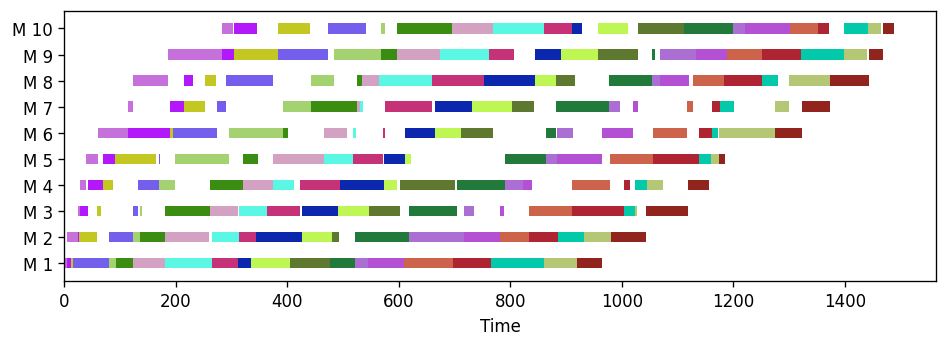

In [7]:
plot_gantt(sol_sm.sequence, dpi=120, seed=42, figsize=[8, 3])

In this implmentation lower bounds are computed by
the max of a single machine and
a two machine relaxations.

The bounds for single and two-machine problems are described
by Potts (1980), also implemented by Ladhari & Haouari (2005),
therein described as 'LB1' and 'LB5'.

The warmstart strategy is proposed by Palmer (1965).

## References

Ladhari, T., & Haouari, M. (2005). A computational study of
the permutation flow shop problem based on a tight lower bound.
Computers & Operations Research, 32(7), 1831-1847.

Potts, C. N. (1980). An adaptive branching rule for the permutation
flow-shop problem. European Journal of Operational Research, 5(1), 19-25.

Palmer, D. S. (1965). Sequencing jobs through a multi-stage process
in the minimum total time—a quick method of obtaining a near optimum.
Journal of the Operational Research Society, 16(1), 101-107

In [8]:
import pyomo.environ as pyo

model = pyo.ConcreteModel()

# Sets for machines, jobs, horizon, and job sequences
model.M = pyo.Set(initialize=range(len(p[0])))
model.J = pyo.Set(initialize=range(len(p)))
model.K = pyo.Set(initialize=range(len(p)))

# Parameters
model.p = pyo.Param(model.J, model.M, initialize=lambda _, m, j: p[m][j])
model.V = pyo.Param(initialize=sum(pim for pi in p for pim in pi))

# Variables
model.x = pyo.Var(model.J, model.K, within=pyo.Binary)
model.h = pyo.Var(model.M, model.K, within=pyo.NonNegativeReals)
model.C = pyo.Var(within=pyo.NonNegativeReals)


# Constraints
def cstr_position(model, k):
    return sum(model.x[j, k] for j in model.J) == 1


def cstr_job(model, j):
    return sum(model.x[j, k] for k in model.K) == 1


def cstr_seq(model, m, k):
    if k == model.K.last():
        return pyo.Constraint.Skip
    return (
        model.h[m, k] + sum(model.p[j, m] * model.x[j, k] for j in model.J)
        <= model.h[m, k + 1]
    )


def cstr_precede(model, m, k):
    if m == model.M.last():
        return pyo.Constraint.Skip
    return (
        model.h[m, k] + sum(model.p[j, m] * model.x[j, k] for j in model.J)
        <= model.h[m + 1, k]
    )


def cstr_comp_precede(model, j, k):
    if j == k:
        return model.z[j, k] + model.z[k, j] == 0.0
    return model.z[j, k] + model.z[k, j] == 1.0


def cstr_total_time(model, m):
    k = model.K.last()
    return (
        model.h[m, k] + sum(model.p[j, m] * model.x[j, k] for j in model.J)
        <= model.C
    )


model.cstr_position = pyo.Constraint(model.K, rule=cstr_position)
model.cstr_job = pyo.Constraint(model.K, rule=cstr_job)
model.cstr_seq = pyo.Constraint(model.M, model.K, rule=cstr_seq)
model.cstr_precede = pyo.Constraint(model.M, model.K, rule=cstr_precede)
model.cstr_total_time = pyo.Constraint(model.M, rule=cstr_total_time)


# Objective
model.obj = pyo.Objective(expr=model.C, sense=pyo.minimize)

# HiGHS
# solver = pyo.SolverFactory('appsi_highs')
# solver.options['mip_heuristic_effort'] = 0.1
# solver.options['time_limit'] = 120
# solver.options['log_file'] = 'Highs.log'
# solver.solve(model, tee=True)

# Gurobi
solver = pyo.SolverFactory("gurobi", solver_io="python")
solver.options["Heuristics"] = 0.2
solver.options["Cuts"] = 2
solver.options["TimeLimit"] = 300
solver.solve(model, tee=True)

Set parameter Heuristics to value 0.2
Set parameter Cuts to value 2
Set parameter TimeLimit to value 300
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 420 rows, 601 columns and 9160 nonzeros
Model fingerprint: 0x1e94bdda
Variable types: 201 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2 rows and 3 columns
Presolve time: 0.13s
Presolved: 418 rows, 598 columns, 8223 nonzeros
Variable types: 20 continuous, 578 integer (400 binary)
Found heuristic solution: objective 1955.0000000
Found heuristic solution: objective 1939.0000000

Root relaxation: objective 1.389762e+03, 1602 iterations, 0.06 sec

{'Problem': [{'Name': 'unknown', 'Lower bound': 1474.1064571692643, 'Upper bound': 1493.0, 'Number of objectives': 1, 'Number of constraints': 420, 'Number of variables': 601, 'Number of binary variables': 400, 'Number of integer variables': 400, 'Number of continuous variables': -199, 'Number of nonzeros': 9160, 'Sense': 'minimize', 'Number of solutions': 10}], 'Solver': [{'Name': 'Gurobi 11.03', 'Status': 'aborted', 'Wallclock time': 300.1119999885559, 'Termination condition': 'maxTimeLimit', 'Termination message': 'Optimization terminated because the time expended exceeded the value specified in the TimeLimit parameter.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Bonus - MILP Model

This is the usual Disjunctive MILP model as an alternative to compare performance.

### Position-based model

```python
import pyomo.environ as pyo

model = pyo.ConcreteModel()

# Sets for machines, jobs, horizon, and job sequences
model.M = pyo.Set(initialize=range(len(p[0])))
model.J = pyo.Set(initialize=range(len(p)))
model.K = pyo.Set(initialize=range(len(p)))

# Parameters
model.p = pyo.Param(model.J, model.M, initialize=lambda _, m, j: p[m][j])
model.V = pyo.Param(initialize=sum(pim for pi in p for pim in pi))

# Variables
model.x = pyo.Var(model.J, model.K, within=pyo.Binary)
model.h = pyo.Var(model.M, model.K, within=pyo.NonNegativeReals)
model.C = pyo.Var(within=pyo.NonNegativeReals)


# Constraints
def cstr_position(model, k):
    return sum(model.x[j, k] for j in model.J) == 1


def cstr_job(model, j):
    return sum(model.x[j, k] for k in model.K) == 1


def cstr_seq(model, m, k):
    if k == model.K.last():
        return pyo.Constraint.Skip
    return (
        model.h[m, k] + sum(model.p[j, m] * model.x[j, k] for j in model.J)
        <= model.h[m, k + 1]
    )


def cstr_precede(model, m, k):
    if m == model.M.last():
        return pyo.Constraint.Skip
    return (
        model.h[m, k] + sum(model.p[j, m] * model.x[j, k] for j in model.J)
        <= model.h[m + 1, k]
    )


def cstr_comp_precede(model, j, k):
    if j == k:
        return model.z[j, k] + model.z[k, j] == 0.0
    return model.z[j, k] + model.z[k, j] == 1.0


def cstr_total_time(model, m):
    k = model.K.last()
    return (
        model.h[m, k] + sum(model.p[j, m] * model.x[j, k] for j in model.J)
        <= model.C
    )


model.cstr_position = pyo.Constraint(model.K, rule=cstr_position)
model.cstr_job = pyo.Constraint(model.K, rule=cstr_job)
model.cstr_seq = pyo.Constraint(model.M, model.K, rule=cstr_seq)
model.cstr_precede = pyo.Constraint(model.M, model.K, rule=cstr_precede)
model.cstr_total_time = pyo.Constraint(model.M, rule=cstr_total_time)


# Objective
model.obj = pyo.Objective(expr=model.C, sense=pyo.minimize)

# HiGHS
solver = pyo.SolverFactory('appsi_highs')
solver.options['mip_heuristic_effort'] = 0.1
solver.options['time_limit'] = 120
solver.options['log_file'] = 'Highs.log'
solver.solve(model, tee=True)

# Gurobi
solver = pyo.SolverFactory("gurobi", solver_io="python")
solver.options["Heuristics"] = 0.2
solver.options["Cuts"] = 2
solver.options["TimeLimit"] = 120
solver.solve(model, tee=True)
```


### Disjunctive model

In experiments with 15 jobs and 8 machines, the Lazy implementation solved in 24s whereas with a time limit of 120s Gurobi could not reach the optimal solution (with a MIP gap of nearly 25%).

```python
import pyomo.environ as pyo

model = pyo.ConcreteModel()

# Sets for machines, jobs, horizon, and job sequences
model.M = pyo.Set(initialize=range(len(p[0])))
model.J = pyo.Set(initialize=range(len(p)))

# Parameters
model.p = pyo.Param(model.J, model.M, initialize=lambda _, m, j: p[m][j])
model.V = pyo.Param(initialize=sum(pim for pi in p for pim in pi))

# Variables
model.x = pyo.Var(model.J, model.M, within=pyo.NonNegativeReals)
model.z = pyo.Var(model.J, model.J, within=pyo.Binary)
model.C = pyo.Var(within=pyo.NonNegativeReals)


# Constraints
def cstr_seq(model, j, m):
    if m == model.M.last():
        return pyo.Constraint.Skip
    return model.x[j, m] + model.p[j, m] <= model.x[j, m + 1]


def cstr_precede(model, j, k, m):
    return model.x[j, m] + model.p[j, m] <= model.x[k, m] + model.V * (
        1 - model.z[j, k]
    )


def cstr_comp_precede(model, j, k):
    if j == k:
        return model.z[j, k] + model.z[k, j] == 0.0
    return model.z[j, k] + model.z[k, j] == 1.0


def cstr_total_time(model, j, m):
    return model.x[j, m] + model.p[j, m] <= model.C


model.cstr_seq = pyo.Constraint(model.J, model.M, rule=cstr_seq)
model.cstr_precede = pyo.Constraint(
    model.J, model.J, model.M, rule=cstr_precede
)
model.cstr_comp_precede = pyo.Constraint(
    model.J, model.J, rule=cstr_comp_precede
)
model.cstr_total_time = pyo.Constraint(model.J, model.M, rule=cstr_total_time)


# Objective
model.obj = pyo.Objective(expr=model.C, sense=pyo.minimize)

# HiGHS
solver = pyo.SolverFactory("appsi_highs")
solver.options["mip_heuristic_effort"] = 0.1
solver.options["time_limit"] = 120
solver.options["log_file"] = "Highs.log"
solver.solve(model, tee=True)

# Gurobi
solver = pyo.SolverFactory("gurobi", solver_io="python")
solver.options["Heuristics"] = 0.2
solver.options["Cuts"] = 2
solver.options["TimeLimit"] = 120
solver.solve(model, tee=True)
```

In [17]:
import pyomo.environ as pyo

model = pyo.ConcreteModel()

# Sets for machines, jobs, horizon, and job sequences
model.M = pyo.Set(initialize=range(len(p[0])))
model.J = pyo.Set(initialize=range(len(p)))

# Parameters
model.p = pyo.Param(model.J, model.M, initialize=lambda _, m, j: p[m][j])
model.V = pyo.Param(initialize=sum(pim for pi in p for pim in pi))

# Variables
model.x = pyo.Var(model.J, model.M, within=pyo.NonNegativeReals)
model.z = pyo.Var(model.J, model.J, within=pyo.Binary)
model.C = pyo.Var(within=pyo.NonNegativeReals)


# Constraints
def cstr_seq(model, j, m):
    if m == model.M.last():
        return pyo.Constraint.Skip
    return model.x[j, m] + model.p[j, m] <= model.x[j, m + 1]


def cstr_precede(model, j, k, m):
    return model.x[j, m] + model.p[j, m] <= model.x[k, m] + model.V * (
        1 - model.z[j, k]
    )


def cstr_comp_precede(model, j, k):
    if j == k:
        return model.z[j, k] + model.z[k, j] == 0.0
    return model.z[j, k] + model.z[k, j] == 1.0


def cstr_total_time(model, j, m):
    return model.x[j, m] + model.p[j, m] <= model.C


model.cstr_seq = pyo.Constraint(model.J, model.M, rule=cstr_seq)
model.cstr_precede = pyo.Constraint(
    model.J, model.J, model.M, rule=cstr_precede
)
model.cstr_comp_precede = pyo.Constraint(
    model.J, model.J, rule=cstr_comp_precede
)
model.cstr_total_time = pyo.Constraint(model.J, model.M, rule=cstr_total_time)


# Objective
model.obj = pyo.Objective(expr=model.C, sense=pyo.minimize)

# HiGHS
# solver = pyo.SolverFactory("appsi_highs")
# solver.options["mip_heuristic_effort"] = 0.1
# solver.options["time_limit"] = 120
# solver.options["log_file"] = "Highs.log"
# solver.solve(model, tee=True)

# Gurobi
solver = pyo.SolverFactory("gurobi", solver_io="python")
solver.options["Heuristics"] = 0.2
solver.options["Cuts"] = 2
solver.options["TimeLimit"] = 120
solver.solve(model, tee=True)

Set parameter Heuristics to value 0.2
Set parameter Cuts to value 2
Set parameter TimeLimit to value 120
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 720 rows, 126 columns and 1735 nonzeros
Model fingerprint: 0xac0c453b
Variable types: 101 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 125 rows and 15 columns
Presolve time: 0.02s
Presolved: 595 rows, 111 columns, 1590 nonzeros
Variable types: 101 continuous, 10 integer (10 binary)
Found heuristic solution: objective 1533.0000000

Root relaxation: objective 1.207000e+03, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current N

{'Problem': [{'Name': 'unknown', 'Lower bound': 1426.0, 'Upper bound': 1426.0, 'Number of objectives': 1, 'Number of constraints': 720, 'Number of variables': 126, 'Number of binary variables': 25, 'Number of integer variables': 25, 'Number of continuous variables': 76, 'Number of nonzeros': 1735, 'Sense': 'minimize', 'Number of solutions': 3}], 'Solver': [{'Name': 'Gurobi 11.03', 'Status': 'ok', 'Wallclock time': 0.27900004386901855, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}